In [531]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path_gender = "gender_submission.csv"
file_path_train = "train.csv"
file_path_test = "test.csv"

In [532]:
def replace_embarked(embarked):
    if embarked == 'Q':
        return 1
    elif embarked == 'S':
        return 2
    else:
        return 3

In [533]:
def replace_gender(gender):
    if gender == 'male':
        return 1
    else:
        return 2

In [534]:
def replace_name(name):
    if "Mrs." in name:
        return 1
    elif "Mr." in name:
        return 2
    else:
        return 3

In [535]:
def initialise_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}

    for l in range(1, len(layer_dims)):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [536]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [537]:
def sigmoid_backward_propagation(dA, cache):
    z = cache
    s = 1/ (1 + np.exp(-z))
    return dA * s * (1-s)

In [538]:
def leaky_relu(Z):
    cache = Z
    A = np.maximum(0.01 * Z, Z)
    return A, cache;

In [539]:
def leaky_relu_back_propagation(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0.01
    dZ[Z >= 0] = 1
    assert (dZ.shape == Z.shape)
    return dZ

In [540]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

In [541]:
def linear_forward_propagation(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    -- the input of the activation function, also called pre-activation parameter
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    cache = (A, W, b)
    return W.dot(A) + b, cache

In [542]:
def forward_propagation(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    if activation == "sigmoid":
        Z, linear_cache = linear_forward_propagation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward_propagation(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

In [543]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        A, cache = forward_propagation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = forward_propagation(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert(AL.shape == (1,X.shape[1]))

    return AL, caches

In [544]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    # print(AL)
    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

In [545]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [546]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward_propagation(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [547]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [548]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward
    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


In [549]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m) * 100))
    return p

In [550]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(1)
    costs = []
    parameters = initialise_parameters(layers_dims)

    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###

        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###

        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###

        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

gender_submission.csv


<AxesSubplot:>

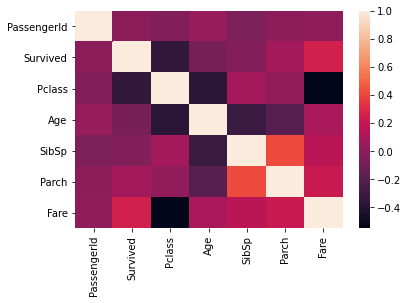

In [551]:
print(file_path_gender)
df_gender = pd.read_csv(file_path_gender)
df_train = pd.read_csv(file_path_train)

### Let's build our input Matrix

X_embarked = df_train.Embarked.map(lambda df: replace_embarked(df))
X_gender = df_train.Sex.map(lambda df: replace_gender(df))
X_name = df_train.Name.map(lambda df: replace_name(df))
X_class = df_train.Pclass
X_sib = df_train.SibSp
X_parch = df_train.Parch
X_fare = df_train.Fare
X_age = df_train.Age
X_survived = df_train.Survived

sns.heatmap(df_train.corr())

In [552]:
X = pd.concat([X_gender, X_class, X_name, X_embarked, X_sib, X_fare, X_parch, X_age, X_survived], axis=1)
# drop the nan values from age
X = X[X.Age.notna()]

Y = X["Survived"]
Y = np.array(Y).reshape((714, 1))
X = X.drop(columns=['Survived'], axis=1)
X = np.array(X).transpose()

print(X)

[[ 1.      2.      2.     ...  2.      1.      1.    ]
 [ 3.      1.      3.     ...  1.      1.      3.    ]
 [ 2.      1.      3.     ...  3.      2.      2.    ]
 ...
 [ 7.25   71.2833  7.925  ... 30.     30.      7.75  ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [22.     38.     26.     ... 19.     26.     32.    ]]


Cost after iteration 0: 0.693139
Cost after iteration 100: 0.676196
Cost after iteration 200: 0.640320
Cost after iteration 300: 0.630900
Cost after iteration 400: 0.628604
Cost after iteration 500: 0.627397
Cost after iteration 600: 0.625864
Cost after iteration 700: 0.622440
Cost after iteration 800: 0.629027
Cost after iteration 900: 0.616682
Cost after iteration 1000: 0.613519
Cost after iteration 1100: 0.609560
Cost after iteration 1200: 0.606649
Cost after iteration 1300: 0.601759
Cost after iteration 1400: 0.597183
Cost after iteration 1500: 0.597372
Cost after iteration 1600: 0.586713
Cost after iteration 1700: 0.580615
Cost after iteration 1800: 0.603973
Cost after iteration 1900: 0.592455
Cost after iteration 2000: 0.562842
Cost after iteration 2100: 0.583938
Cost after iteration 2200: 0.618115
Cost after iteration 2300: 0.549948
Cost after iteration 2400: 0.575616
Cost after iteration 2500: 0.570278
Cost after iteration 2600: 0.541176
Cost after iteration 2700: 0.656020
Cost

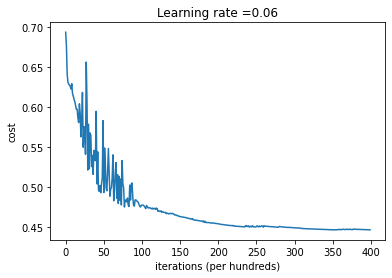

In [553]:
layer_dimensions = [8, 3, 5, 1]
initialise_parameters(layer_dimensions)
parameters = L_layer_model(X, Y.transpose(),layer_dimensions, learning_rate=0.06, num_iterations = 40000, print_cost=True)

In [554]:
df_test = pd.read_csv(file_path_test)
X_embarked = df_test.Embarked.map(lambda df: replace_embarked(df))
X_gender = df_test.Sex.map(lambda df: replace_gender(df))
X_name = df_test.Name.map(lambda df: replace_name(df))
X_class = df_test.Pclass
X_sib = df_test.SibSp
X_parch = df_test.Parch
X_fare = df_test.Fare
X_age = df_test.Age

X = pd.concat([X_gender, X_class, X_name, X_embarked, X_sib, X_fare, X_parch, X_age], axis=1)
X = np.array(X).transpose()
#print(X.shape)
Y = df_gender.Survived
Y = np.array(Y)
# print(Y.shape)
predict(X, Y, parameters)

Accuracy: 86.36363636363636


array([[0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 